In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
from torch.autograd.functional import jacobian

matplotlib.rcParams['figure.figsize'] = (25, 5)

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params


In [62]:
cfg = mlc.ConfigDict()
cfg.factor_dim = 5
cfg.obs_dim = 100
cfg.p_factor = 5
cfg.covar_factor = np.eye(cfg.factor_dim)/2000
cfg.p_eps = 0
cfg.covar_eps = 0 *np.eye(cfg.obs_dim)/2000


## Nonlinear decoder DGP
Obtain the simulated $y$

Obtained stable system after 195 iterations.
Theoretical optimal mse for f, y, enc: 117.352


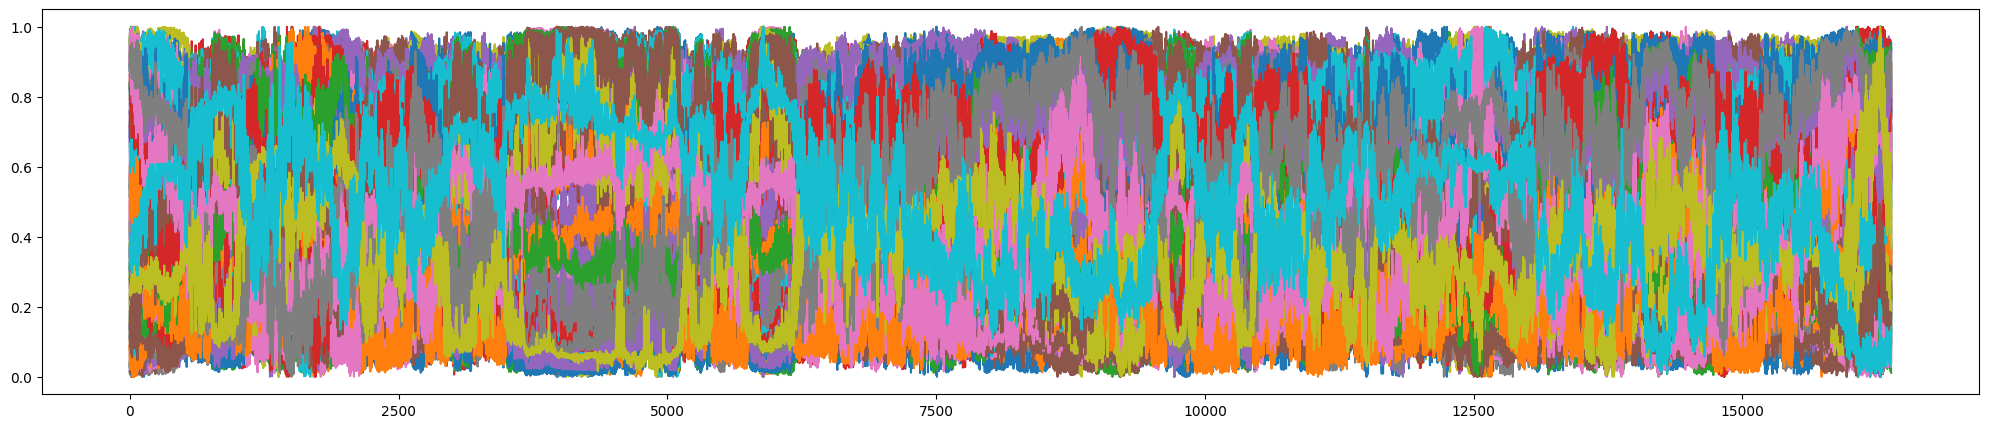

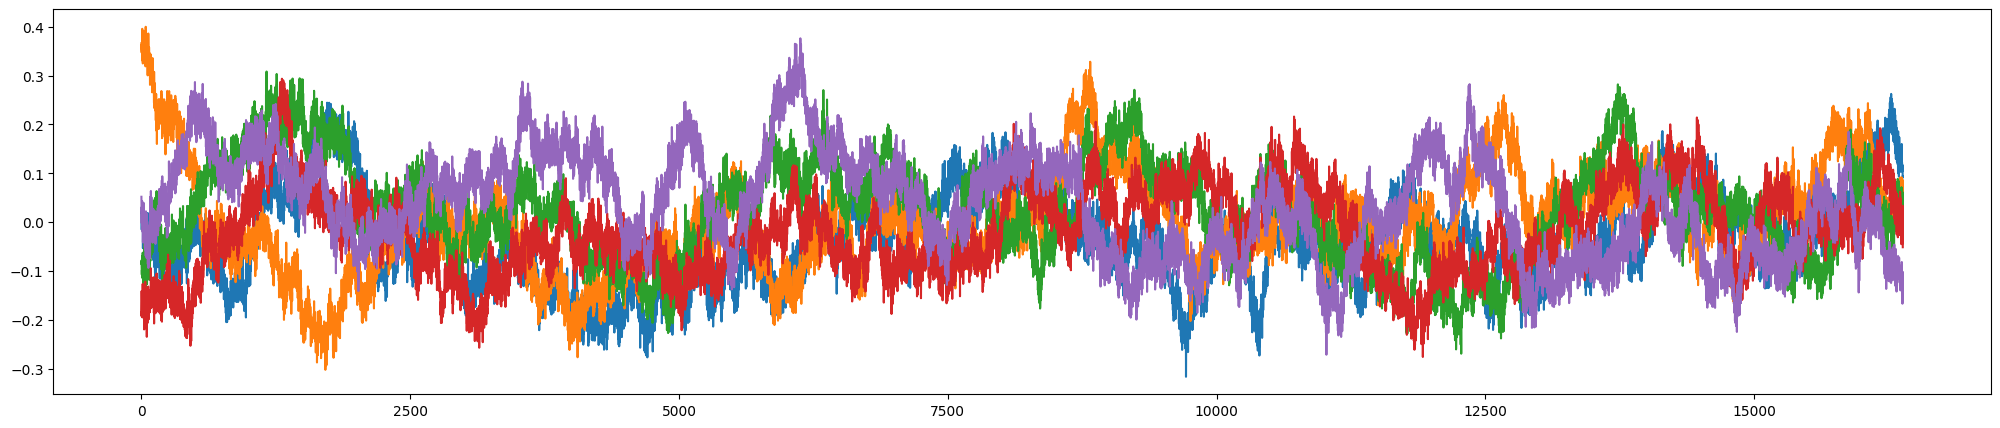

In [67]:
def init_function(params): 
    #return torch.nn.init.normal_(params,mean=0,std=10)
    a = 2
    #return torch.nn.init.uniform_(params,  -a,a)
    #return torch.nn.init.constant_(params,10)
    return torch.nn.init.sparse_(params, 0, std=1.8)

dec = Decoder(hidden_dim=[cfg.factor_dim, 10,20,30,40,50,60,70,80, cfg.obs_dim], activation=nn.Sigmoid, lastLayerLinear=True, init_function=init_function)
f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=16384, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=True, centered=True)
plt.plot(y);
plt.figure()
#plt.plot(obs_residual);
#plt.figure()
#plt.plot(y-obs_residual);
#plt.figure()
plt.plot(f);

In [68]:
from sklearn.decomposition import PCA
from statsmodels.multivariate.cancorr import CanCorr
pca = PCA(n_components=cfg.factor_dim)
f_train_hat = pca.fit_transform(y[0:1000])
#f_val_hat = pca.fit_transform(y_val)
f_test = pca.transform(y[1000:])
cancorr = CanCorr(f_test, f[1000:])
cc = np.mean(cancorr.cancorr)
print(cc)

0.5264600242590551


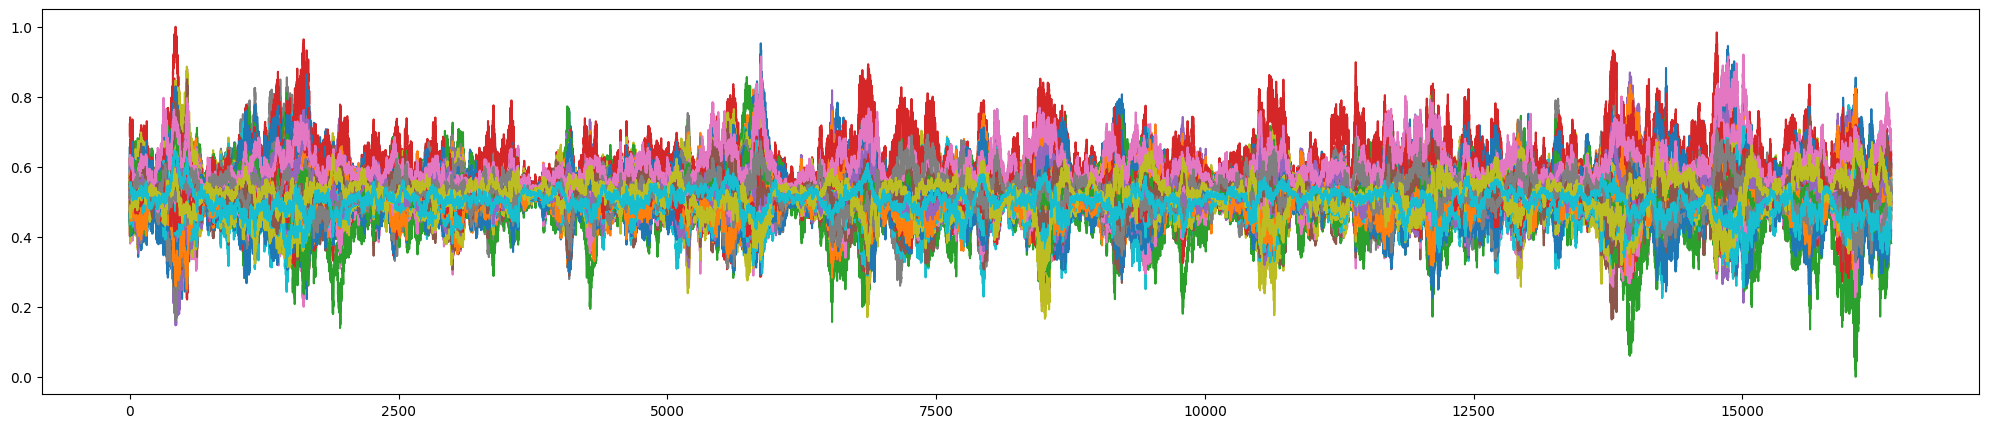

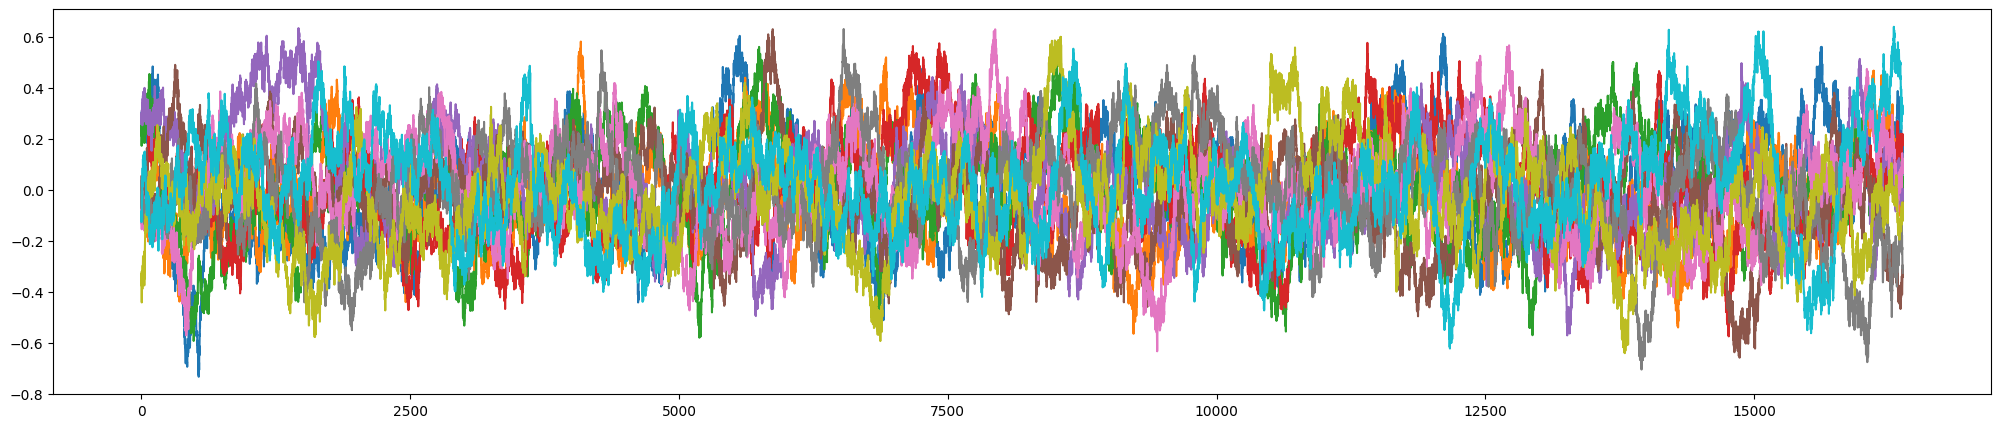

In [128]:
from scipy.stats import norm
b = np.random.normal(size=(10,100), scale = 1)
#b = np.random.uniform(-1,1, size=(10,100))
y = f**2 @ b
#y = norm.pdf(f*10) @b
#y = 1/(1+np.exp(- f @ b))
#y = np.sin(f @ b)
#y = y - y.mean(axis=0)
y = (y - y.min())/(y.max() - y.min())
plt.plot(y);
plt.figure()
plt.plot(f);

In [69]:
i=20
torch.save(dec, f'../DGP/saved/dec_{i}.pt')
np.save(arr=y, file=f'../DGP/saved/y_{i}.npy')
np.save(arr=f, file=f'../DGP/saved/f_{i}.npy')

In [75]:
#j = jacobian(dec, torch.Tensor(f[0]).float()).detach().numpy()
#cov = j @ cfg.covar_factor @ j.T
#cov.shape

In [33]:
get_trainable_params(dec)

16500

## Estimate nonlinear model
TODO: this should all be hyperparameter tuned etc.

In [289]:
dec = Decoder(hidden_dim=[cfg.factor_dim, cfg.obs_dim], activation=nn.Identity(), lastLayerLinear=False)
enc = Encoder(hidden_dim=[cfg.obs_dim, cfg.factor_dim], activation=nn.Identity(), lastLayerLinear=False)
mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainanle paramaters {get_trainable_params(mod)}")
criterion = BasicAutoEncoder.model.OrthoLoss(enc=enc, alpha=10)
train_hist = train(X=y,model=mod,n_epoch=3000, lr = 0.0001)
print(f"Training loss: {train_hist['loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")

Number of trainanle paramaters 225
split 700
(1000, 20) (299, 20)
1000 5
Training loss: 0.002788597654381936, Validation Loss: 0.05205743759870529


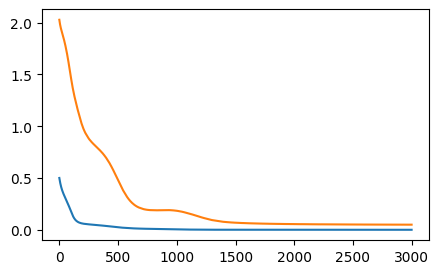

In [290]:
plot_train_hist(train_hist, log=False)

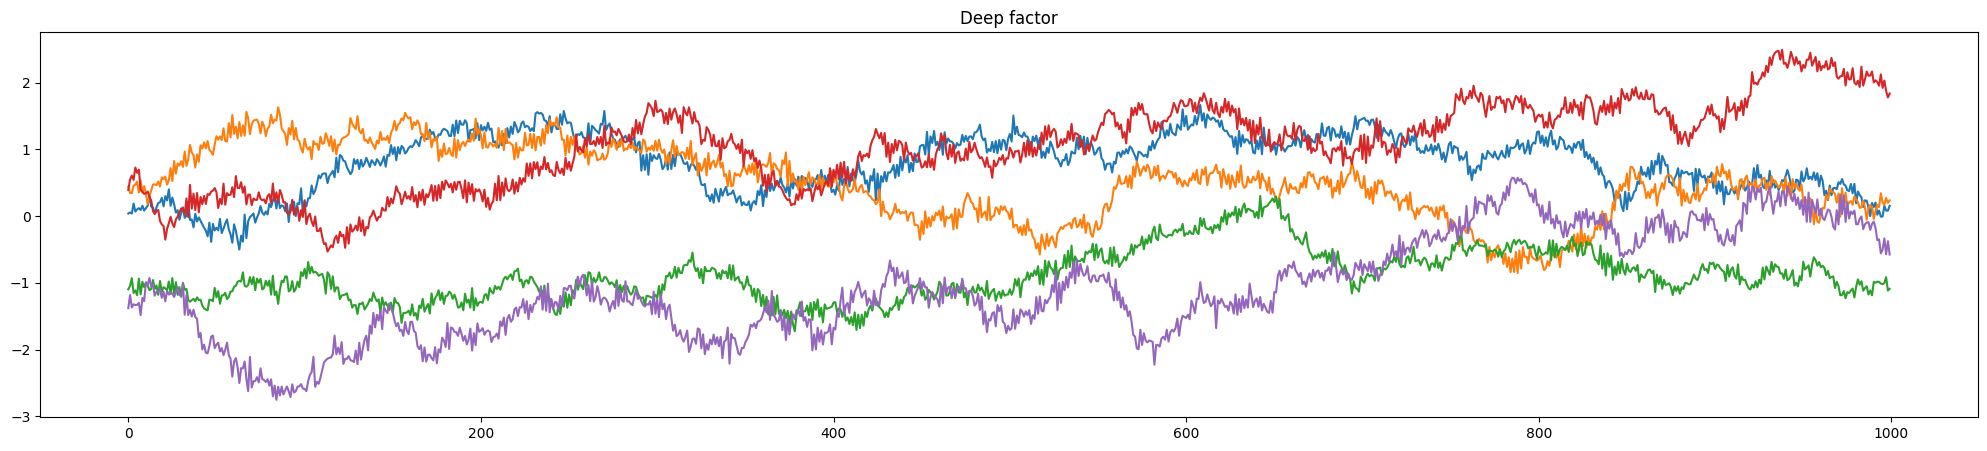

In [291]:
plot_factor_estimates(mod, y)

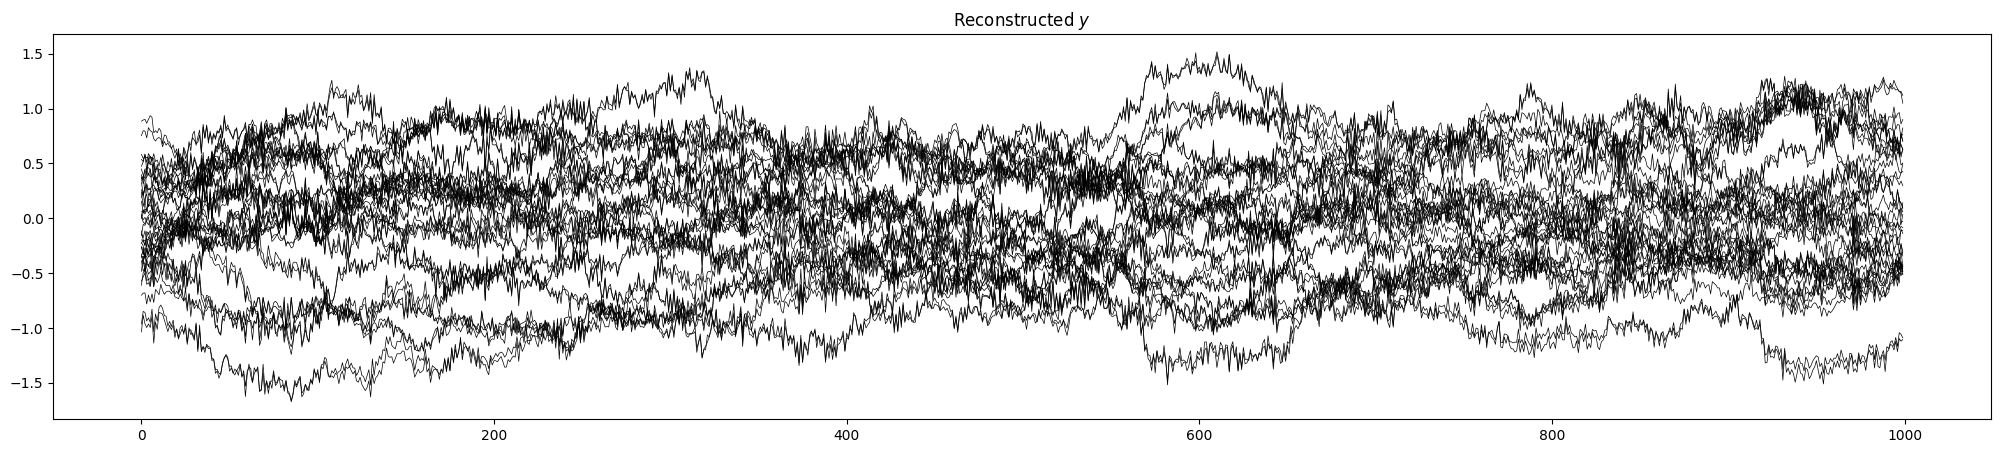

In [292]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);

In [293]:
f_hat = mod.enc(torch.Tensor(y).float()).detach().numpy()

In [200]:
f

#(XtX)-1Xty

(500, 10)

In [272]:
beta = np.linalg.inv(f.T@f)@f.T@f_hat

In [277]:
beta

array([[ 0.06004549, -0.5032426 ,  0.32140719, -0.13817794,  0.73541007],
       [ 0.36842814, -0.46714959,  0.3844248 ,  0.38268035, -0.46529917],
       [ 0.38384999,  0.83545479, -0.61048691, -0.00596038,  0.14088445],
       [-0.39606755, -0.62764808, -0.84093786,  0.08457001,  0.53412486],
       [ 0.69939271, -0.00084112, -0.12845446, -0.76571923, -0.01555817]])

In [214]:
(beta@f_hat.T).shape

()

(10, 500)

In [294]:
f_pred  = (beta@f_hat.T).T
ssr = np.sum((f-f_pred)**2,axis=0)
sst = np.sum((f-np.mean(f))**2,axis=0)
r2 = 1 - ssr/sst
print(r2)

[-8.31245382 -2.77849639 -1.13967189  0.66116002 -1.55617087]


In [222]:
sst

1921.0287815376507

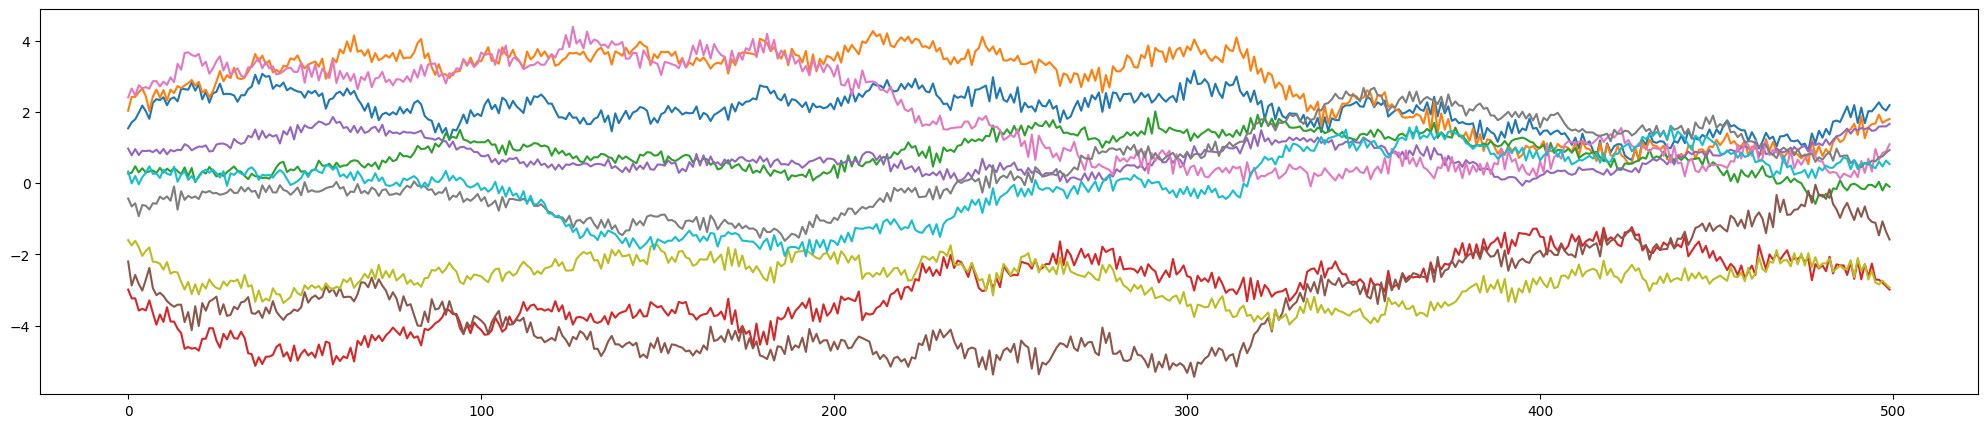

In [217]:
plt.plot((beta@f_hat.T).T);

In [295]:
from sklearn.cross_decomposition import CCA
cca = CCA(n_components=5)
cca.fit(X=f_hat, Y=f)

/usr/local/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:110: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


CCA(n_components=5)

In [296]:
cca.score(f_hat, f)

0.978637046574988

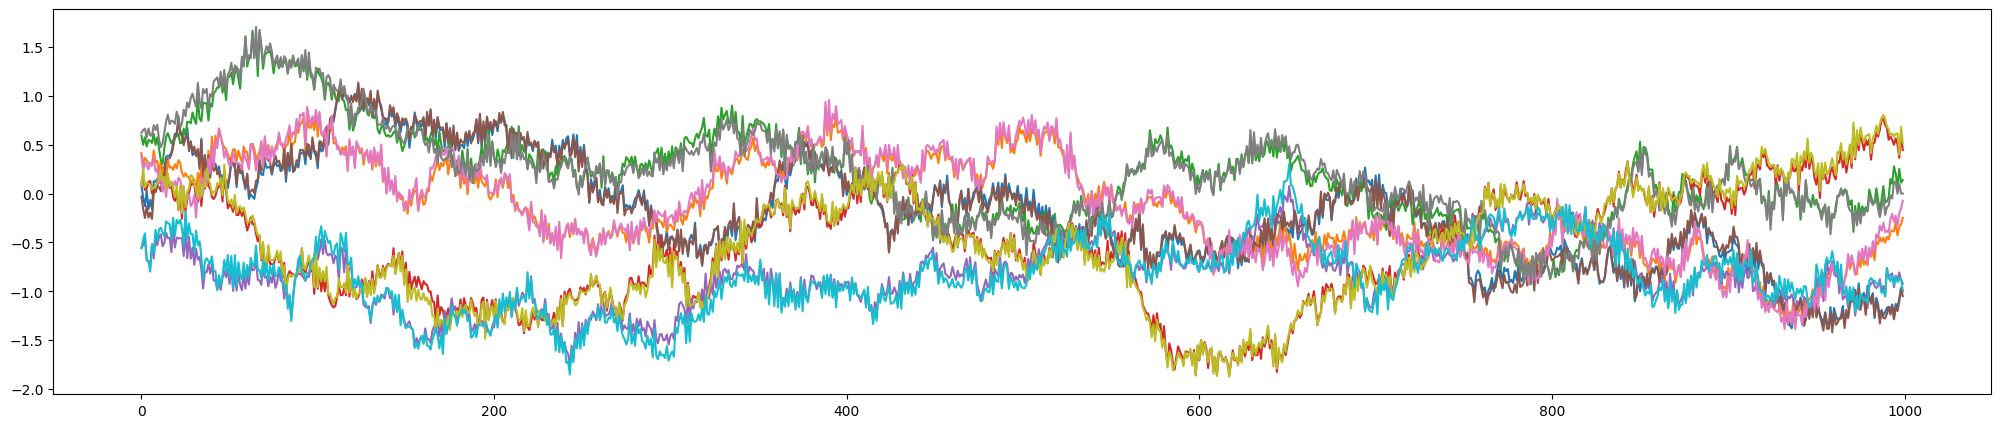

In [299]:
plt.plot(cca.predict(f_hat),  c='b')
plt.plot(f, c='b')

In [284]:
cca.x_loadings_

array([[-0.43750242,  0.77978638, -0.2736465 ,  0.11062488,  0.3135346 ],
       [-0.38752098, -0.1182744 , -0.59781774,  0.77837161, -0.31097472],
       [-0.34004419,  0.27945024,  0.7879441 ,  0.30779222, -0.51259308],
       [-0.19288135, -0.62892401,  0.12157674,  0.47514753,  0.70029709],
       [ 0.85678752,  0.17206361, -0.28027878,  0.24897414,  0.22764688]])